<div class="alert alert-primary alert-info">

# Reinforcement Learning - Blackjack with Monte-Carlo Methods
    
</div>

---

<div class="alert alert-block alert-success">

- ## Monte-Carlo Control

</div>

---

<img src='blackjack.jpg'/>

---

In [2]:
%config IPCompleter.greedy=True
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import sys
from collections import defaultdict

import gym

from mpl_toolkits.mplot3d import Axes3D

In [4]:
np.random.seed(0)

In [5]:
env = gym.make('Blackjack-v0')

---

### Policy:

No existing policy $\implies$ Hit if 20 or 21, Stick otherwise.
Improve on existing policy if one exist.


### Update Rules:

(1) Monte-Carlo Discounted cumulative reward.

$
\begin{align}
q_{\pi}(s, a) &= \mathbf{E}[G_t \mid S_t = s, A_t = a] \\
&= \mathbf{E}[ \sum_{k=0}^{\infty} \gamma^{k} R_{t+k+1}^{a} \mid S_t = s, A_t = a ] \\
\end{align}
$

---

(2) Temporal Differences

$q_{\pi}(s, a) = q_{\pi}(s, a) + \eta [ \sum_{k=0, (s', a') \in \pi}^{\infty} \gamma^k R_{s'}^{a'} - q_{\pi}(s, a)]$

---

### Policy Improvement

$\pi_{*} (a \mid s) := \underset{a\in A}{\operatorname{argmax}} q_{\pi}(s, a)$

---

In [6]:
class MonteCarlo_RL:

    def __init__(self, env, gamma, eta):
        self.env = env
        self.gamma = gamma
        self.eta = eta
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
        self.visited_count = defaultdict(lambda: np.zeros(env.action_space.n))
        
    def game(self):
        STICK, HIT = 0, 1
        episode = []
        state = self.env.reset()
        while True:
            if np.all((self.Q[state] == 0)): # if no existing policy yet
                action = HIT
                if state[0] in [20, 21]:
                    action = STICK
            else:
                action = np.argmax(self.Q[state]) # reuse and improve existing policy
            next_state, reward, done, _ = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if done:
                break
        return episode
    
    def mc_control_cumulative_rewards(self, num_episodes, method_name):
        self.num_episodes = num_episodes
        for episode_idx in range(num_episodes):
            episode = self.game()
            self.policy_evaluation_cumulative_rewards(episode)
            for k, v in self.Q.items():
                if self.visited_count[k][0] > 1:
                    v /= self.visited_count[k][0]
                if self.visited_count[k][1] > 1:
                    v /= self.visited_count[k][1]
            self.visited_count.clear()
        action_values = dict((k,np.max(v)) for k, v in self.Q.items())
        self.plot(action_values, method_name)
        policy = self.get_policy()
        return policy
    
    def mc_control_incremental_updates(self, num_episodes, method_name):
        self.num_episodes = num_episodes
        for episode_idx in range(num_episodes):
            episode = self.game()
            self.policy_evaluation_incremental_updates(episode)
        action_values = dict((k,np.max(v)) for k, v in self.Q.items())
        self.plot(action_values, method_name)
        policy = self.get_policy()
        return policy
        
    def policy_evaluation_cumulative_rewards(self, episode):
        for idx, state_action_reward in enumerate(episode):
            state, action, reward = state_action_reward
            idx_first_visited = next(i for i, s_a_r in enumerate(episode) if s_a_r[0] == state)
            if idx > idx_first_visited:
                continue
            self.Q[state][action] += sum([s_a_r[2] * (gamma ** i) for i, s_a_r in enumerate(episode[idx_first_visited:])]) 
            self.visited_count[state][action] += 1
    
    def policy_evaluation_incremental_updates(self, episode):
        for idx, state_action_reward in enumerate(episode):
            state, action, reward = state_action_reward
            idx_first_visited = next(i for i, s_a_r in enumerate(episode) if s_a_r[0] == state)
            if idx > idx_first_visited:
                continue
            g_t = sum([s_a_r[2] * (gamma ** i) for i, s_a_r in enumerate(episode[idx_first_visited:])])
            self.Q[state][action] += self.eta * (g_t - self.Q[state][action])
            self.visited_count[state][action] += 1
    
    def plot(self, action_values, method_title):
        
        def get_z(x, y, usable_ace):
            if (x, y, usable_ace) in action_values:
                return action_values[x, y, usable_ace]
            return 0

        def graph(usable_ace, ax):
            x_domain = np.arange(11, 22)
            y_domain = np.arange(1, 11)
            x_mesh, y_mesh = np.meshgrid(x_domain, y_domain)
            z = np.array([get_z(x,y,usable_ace) for x,y in zip(np.ravel(x_mesh), np.ravel(y_mesh))]).reshape(x_mesh.shape)
            ax.plot_surface(x_mesh, y_mesh, z, rstride=1, cstride=1, cmap=plt.cm.coolwarm)
            ax.set_xlabel('Player State')
            ax.set_ylabel('Dealer showed card')
            ax.set_zlabel('Action State value')
            ax.view_init(ax.elev, -120)
        
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(121, projection='3d')
        ax.set_title('{}\n{}, {} iterations'.format(method_title, 'Usable Ace', str(self.num_episodes)))
        graph(True, ax)
        ax = fig.add_subplot(122, projection='3d')
        ax.set_title('{}\n{}, {} iterations'.format(method_title, 'No Usable Ace', str(self.num_episodes)))
        graph(False, ax)
        plt.show()
        
    def get_policy(self):
        return dict((k,np.argmax(v)) for k, v in self.Q.items())

    def reset(self):
        self.env.reset()
        self.Q.clear()
        self.visited_count.clear()

---

### Start the training $\ldots$

---

In [7]:
env = gym.make('Blackjack-v0')

num_of_episodes = [1000, 100000, 500000]

---

<div class="alert alert-danger" role="alert">

#### $\mathbb{E}[\sum_{k=0}^{\infty} \gamma^k R_{t+k+1}]$
    
</div>

---

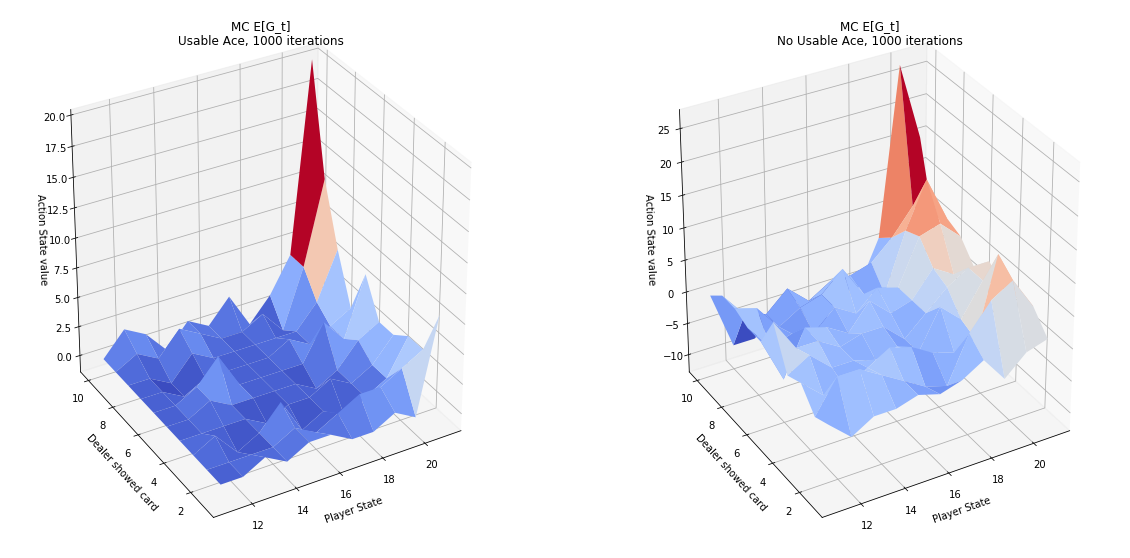

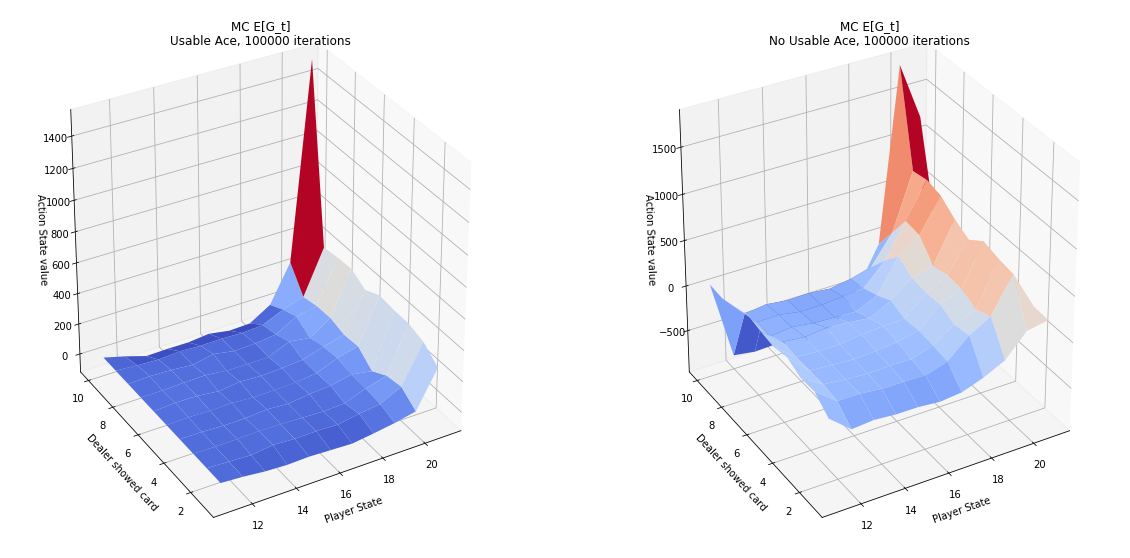

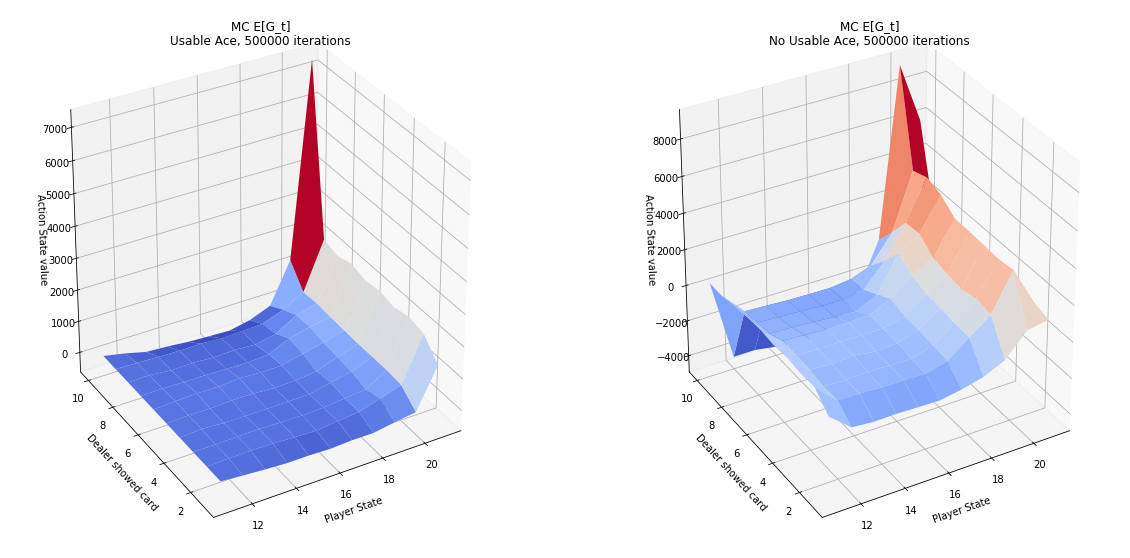

In [8]:
gamma = 1.0
eta = 0.001
method_name = 'MC E[G_t]'

mc_agent = MonteCarlo_RL(env, gamma, eta)

for n in num_of_episodes:
    policy = mc_agent.mc_control_cumulative_rewards(n, method_name)
    mc_agent.reset()

---

<div class="alert alert-danger" role="alert">

### Temporal Differences
    
</div>

---

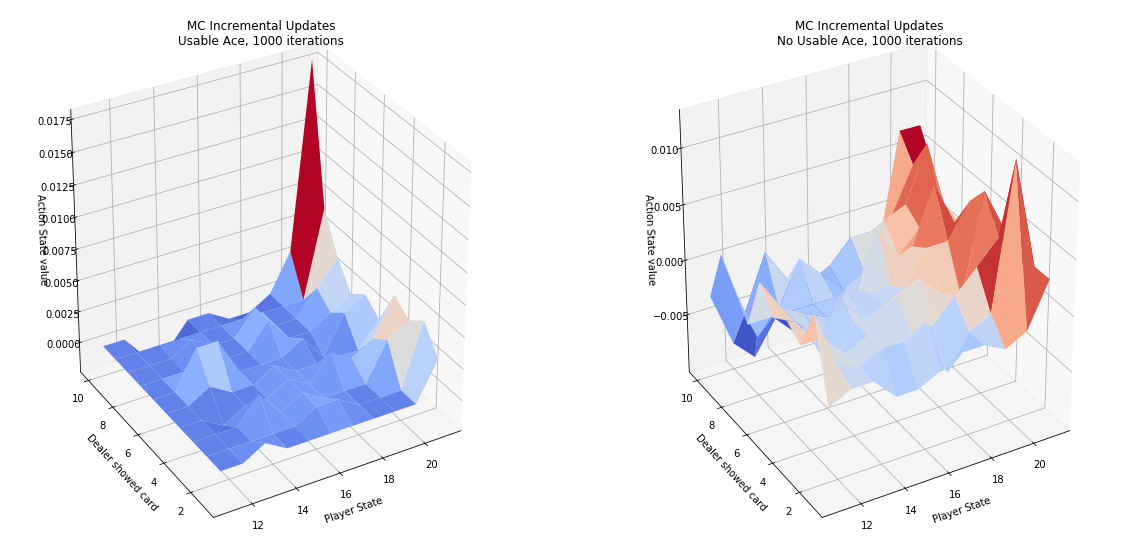

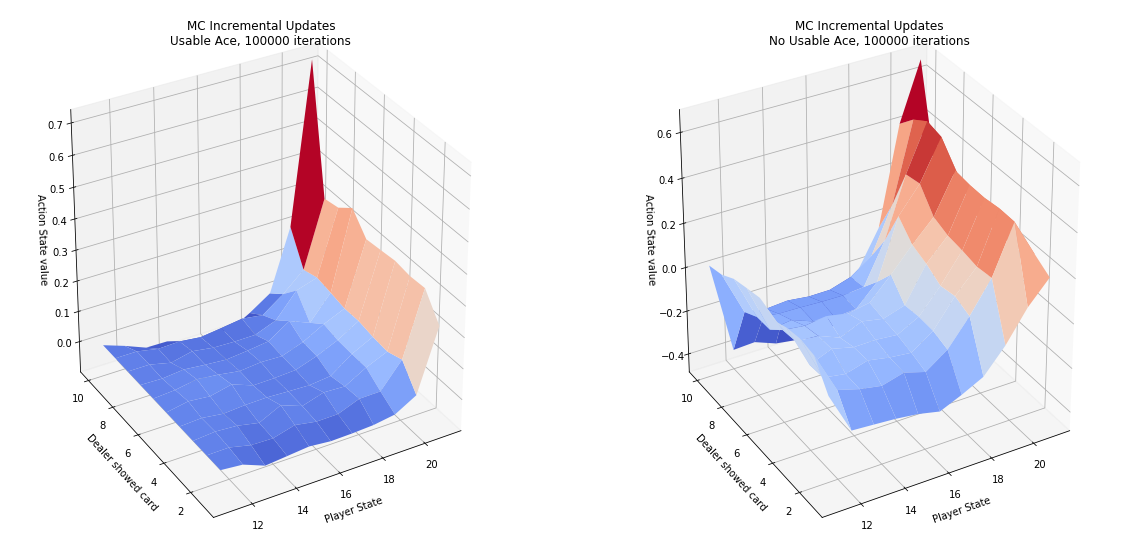

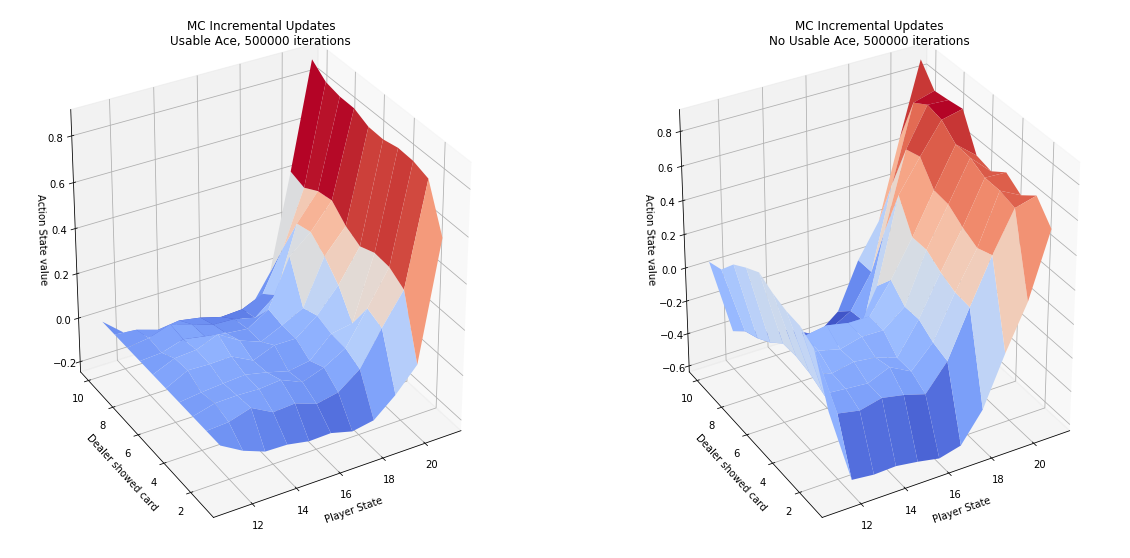

In [9]:
method_name = 'MC Incremental Updates'

mc_agent = MonteCarlo_RL(env, gamma, eta)

for n in num_of_episodes:
    policy = mc_agent.mc_control_incremental_updates(n, method_name)
    mc_agent.reset()